In [118]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA


In [119]:
movies = pd.read_csv('../data/movies_dataset.csv')

In [120]:
movies.head(1)

,budget,id,original_language,revenue,runtime,title,vote_average,vote_count,top_cast,director,genres,keywords,release_year,profit,decade
0,30000000.0,862,en,373554033.0,81.0,Toy Story,7.7,5415.0,"['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",John Lasseter,"['Animation', 'Comedy', 'Family']","['jealousy', 'toy', 'boy', 'friendship', 'frie...",1995,343554033.0,1990


In [121]:
# Checking if genres, top_cast, and keywords are all the same type
print("genres:")
print(type(movies.loc[0, 'genres']))
print(movies.loc[0, 'genres'])
print(type(movies.loc[0, 'genres'][0]))

print("\ntop_cast:")
print(type(movies.loc[0, 'top_cast']))
print(movies.loc[0, 'top_cast'])
print(type(movies.loc[0, 'top_cast'][0]))

print("\nkeywords:")
print(type(movies.loc[0, 'keywords']))
print(movies.loc[0, 'keywords'])
print(type(movies.loc[0, 'keywords'][0]))

genres:
<class 'str'>
['Animation', 'Comedy', 'Family']
<class 'str'>

top_cast:
<class 'str'>
['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim Varney', 'Wallace Shawn']
<class 'str'>

keywords:
<class 'str'>
['jealousy', 'toy', 'boy', 'friendship', 'friends', 'rivalry', 'boy next door', 'new toy', 'toy comes to life']
<class 'str'>


In [122]:
# Convert columns from string to list
for col in ['genres', 'top_cast', 'keywords']:
    movies[col] = movies[col].apply(ast.literal_eval)

### For ML I need to encode my qualitive features, and scale my quantitative features

In [123]:
# Limiting features before encoding
# Keywords - limiting to 100 
all_keywords = pd.Series([kw for kws in movies['keywords'] for kw in kws])
top_keywords = all_keywords.value_counts().head(100).index
movies['keywords'] = movies['keywords'].apply(lambda kws: [kw for kw in kws if kw in top_keywords])

# Actors - limiting to 100
all_actors = pd.Series([actor for cast in movies['top_cast'] for actor in cast])
top_actors = all_actors.value_counts().head(100).index
movies['top_cast'] = movies['top_cast'].apply(lambda cast: [actor for actor in cast if actor in top_actors])

# Directors - limiting to 50
top_directors = movies['director'].value_counts().head(50).index
movies['director'] = movies['director'].apply(lambda d: d if d in top_directors else 'Other')

# I will be skipping genres as they are already limited



In [124]:
# Encoding features
# Genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(movies['genres'])

# Keywords
mlb_keywords = MultiLabelBinarizer()
keywords_encoded = mlb_keywords.fit_transform(movies['keywords'])

# Top Cast
mlb_cast = MultiLabelBinarizer()
cast_encoded = mlb_cast.fit_transform(movies['top_cast'])

# Director (one-hot)
director_encoded = pd.get_dummies(movies['director']).values

# Language (one-hot)
language_encoded = pd.get_dummies(movies['original_language']).values


In [125]:
# Scaling features using StandardScaler
num_features = ['budget', 'revenue', 'runtime', 'profit', 'vote_average', 'vote_count', 'release_year', 'decade']
scaler = StandardScaler()
num_encoded = scaler.fit_transform(movies[num_features])

In [126]:
X = np.hstack([
    genres_encoded,
    keywords_encoded,
    cast_encoded,
    director_encoded,
    language_encoded,
    num_encoded 
])

### First I'll try building a model using KMeans

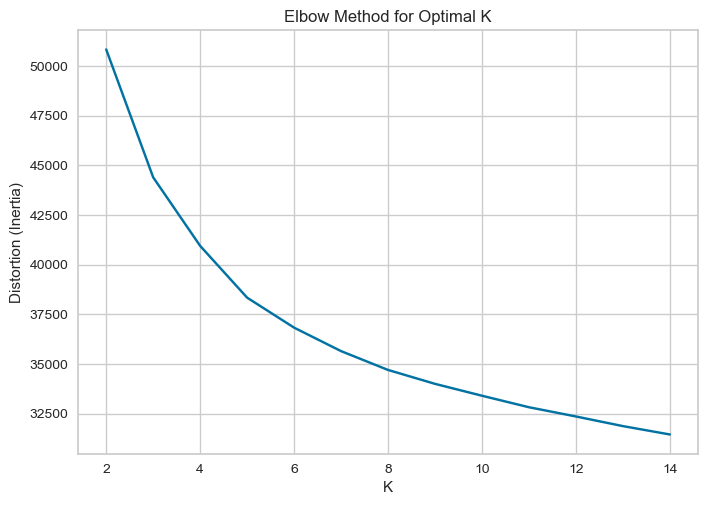

In [127]:
distortions = []
K = range(2, 15)
for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X)
    distortions.append(model.inertia_)  # inertia_ is the sum of squared distances

plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

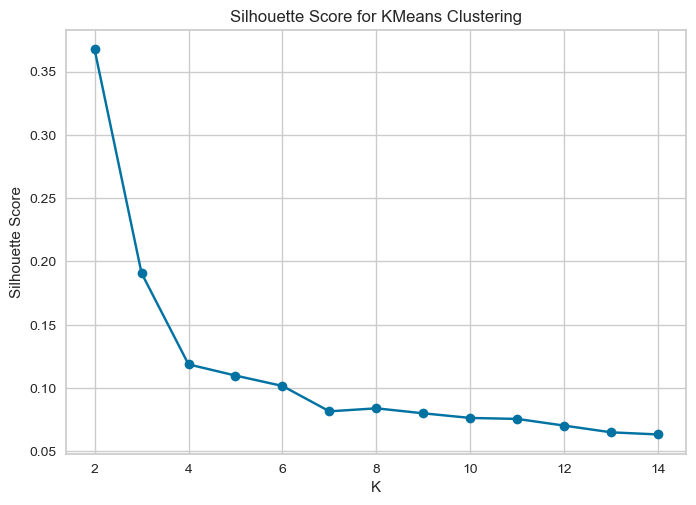

In [128]:
scores = []
for k in K:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.figure()
plt.plot(K, scores, 'bo-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for KMeans Clustering')
plt.show()

### Choice of clusters
The silhoutte score shows the optimal number of clusters would be 2. However, this wouldn't be great for a movie recommendation system, as there would barely be even variety. 
Using the elbow method method instead there is a slight elbow at 5 clusters, so I'll choose 5 clusters instead - although I realize this will not a great silhoutte score. 

In [129]:
k = 5
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
movies['cluster'] = kmeans.fit_predict(X)

In [130]:
print(movies['cluster'].value_counts().sort_index())


cluster
0     623
1     742
2    1866
3    1560
4     149
Name: count, dtype: int64


In [131]:
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    cluster_movies = movies[movies['cluster'] == i]
    print("Top genres:", pd.Series([g for genres in cluster_movies['genres'] for g in genres]).value_counts().head(5))
    print("Top directors:", cluster_movies['director'].value_counts().head(3))
    print("Top languages:", cluster_movies['original_language'].value_counts().head(3))
    print("Example movies:", cluster_movies['title'].head(3).tolist())




Cluster 0:
Top genres: Action       290
Adventure    228
Comedy       215
Thriller     201
Drama        165
Name: count, dtype: int64
Top directors: director
Other               487
Steven Spielberg     14
Robert Zemeckis      12
Name: count, dtype: int64
Top languages: original_language
en    615
zh      3
fr      2
Name: count, dtype: int64
Example movies: ['Toy Story', 'Jumanji', 'GoldenEye']

Cluster 1:
Top genres: Drama        371
Comedy       197
Thriller     185
Action       168
Adventure    153
Name: count, dtype: int64
Top directors: director
Other               594
Alfred Hitchcock     21
Billy Wilder         11
Name: count, dtype: int64
Top languages: original_language
en    719
fr      8
ja      5
Name: count, dtype: int64
Example movies: ['Taxi Driver', 'Blade Runner', 'Snow White and the Seven Dwarfs']

Cluster 2:
Top genres: Comedy      914
Thriller    613
Action      520
Drama       509
Horror      371
Name: count, dtype: int64
Top directors: director
Other            

In [132]:
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id}: Example Movies")
    display(movies[movies['cluster'] == cluster_id][['title', 'genres', 'director', 'original_language', 'vote_average']].head(5))



Cluster 0: Example Movies


,title,genres,director,original_language,vote_average
0,Toy Story,"[Animation, Comedy, Family]",Other,en,7.7
1,Jumanji,"[Adventure, Fantasy, Family]",Other,en,6.9
4,GoldenEye,"[Adventure, Action, Thriller]",Other,en,6.6
16,Twelve Monkeys,"[Science Fiction, Thriller, Mystery]",Terry Gilliam,en,7.4
22,Se7en,"[Crime, Mystery, Thriller]",Other,en,8.1



Cluster 1: Example Movies


,title,genres,director,original_language,vote_average
40,Taxi Driver,"[Crime, Drama]",Martin Scorsese,en,8.1
188,Blade Runner,"[Science Fiction, Drama, Thriller]",Ridley Scott,en,7.9
204,Snow White and the Seven Dwarfs,"[Fantasy, Animation, Family]",Other,en,6.9
206,Pinocchio,"[Animation, Family]",Other,en,6.9
208,The Wild Bunch,"[Adventure, Western]",Other,en,7.7



Cluster 2: Example Movies


,title,genres,director,original_language,vote_average
3,Sudden Death,"[Action, Adventure, Thriller]",Peter Hyams,en,5.5
6,Cutthroat Island,"[Action, Adventure]",Renny Harlin,en,5.7
8,Four Rooms,"[Crime, Comedy]",Other,en,6.5
9,Ace Ventura: When Nature Calls,"[Crime, Comedy, Adventure]",Other,en,6.1
10,Money Train,"[Action, Comedy, Crime]",Other,en,5.4



Cluster 3: Example Movies


,title,genres,director,original_language,vote_average
2,Waiting to Exhale,"[Comedy, Drama, Romance]",Other,en,6.1
5,The American President,"[Comedy, Drama, Romance]",Rob Reiner,en,6.5
7,Sense and Sensibility,"[Drama, Romance]",Other,en,7.2
12,Assassins,"[Action, Adventure, Crime, Thriller]",Richard Donner,en,6.0
13,Leaving Las Vegas,"[Drama, Romance]",Other,en,7.1



Cluster 4: Example Movies


,title,genres,director,original_language,vote_average
95,Star Wars,"[Adventure, Action, Science Fiction]",Other,en,8.1
125,Forrest Gump,"[Comedy, Drama, Romance]",Robert Zemeckis,en,8.2
128,The Lion King,"[Family, Animation, Drama]",Other,en,8.0
162,Jurassic Park,"[Adventure, Science Fiction]",Steven Spielberg,en,7.6
201,Terminator 2: Judgment Day,"[Action, Thriller, Science Fiction]",Other,en,7.7


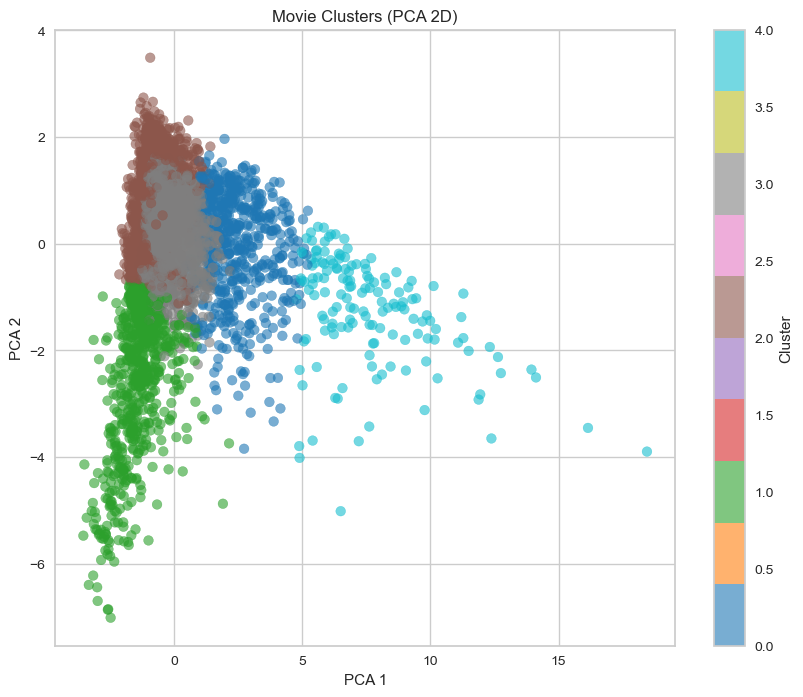

In [133]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=movies['cluster'], cmap='tab10', alpha=0.6)
plt.title('Movie Clusters (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')
plt.show()


In [134]:
score = silhouette_score(X, movies['cluster'])
print(f'Silhouette Score for K={optimal_k}: {score:.3f}')

Silhouette Score for K=5: 0.110


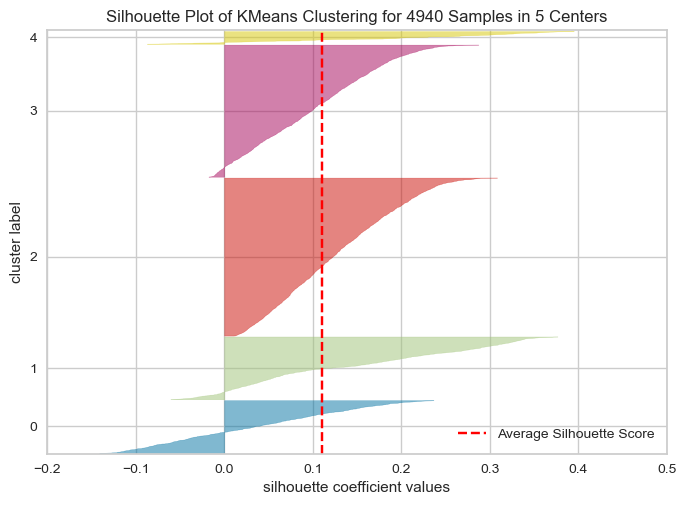

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 4940 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [135]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()


### Since the result from K-Means wasn't promising, I'll try building a model using Mean-Shift as well

In [136]:
# For large datasets, you can set n_samples to a lower value for speed
bandwidth = estimate_bandwidth(X, quantile=0.05, n_samples=500)
print("Estimated bandwidth:", bandwidth)


Estimated bandwidth: 3.2801008742620956


In [137]:
msmodel = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msmodel.fit(X)
labels = msmodel.labels_
n_clusters_ = msmodel.cluster_centers_.shape[0] 
cluster_centers = msmodel.cluster_centers_
print("Number of clusters found:", n_clusters_)
print("Counts per cluster:", np.bincount(labels))


Number of clusters found: 3
Counts per cluster: [4677  241   22]


In [138]:
movies['ms_cluster'] = labels

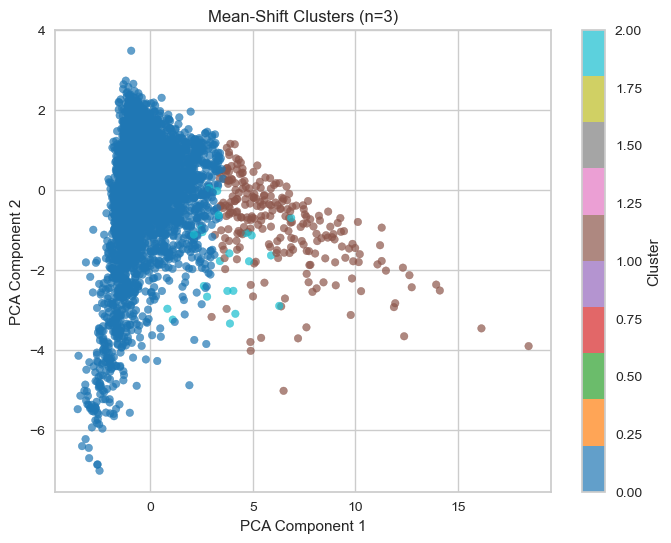

In [139]:
# Scatter plot of clusters
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
plt.title(f'Mean-Shift Clusters (n={n_clusters_})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


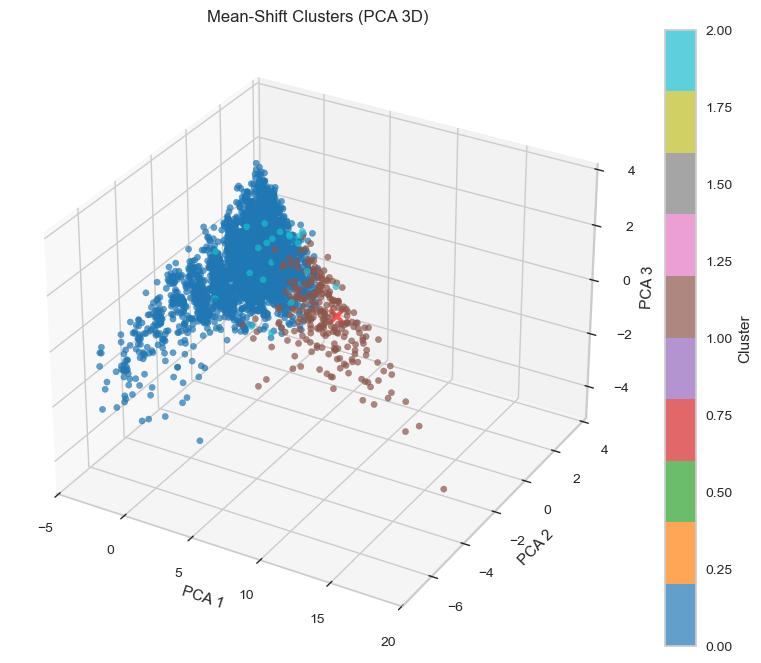

In [140]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
X_3d = pca.fit_transform(X)
centers_3d = pca.transform(cluster_centers)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, cmap='tab10', s=20, alpha=0.7)
ax.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2], marker='x', color='red', s=100, linewidth=3, zorder=10)
ax.set_title('Mean-Shift Clusters (PCA 3D)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(sc, label='Cluster')
plt.show()


In [141]:
for i in range(n_clusters_):
    print(f"\nCluster {i}:")
    cluster_movies = movies[movies['ms_cluster'] == i]
    print("Top genres:", pd.Series([g for genres in cluster_movies['genres'] for g in genres]).value_counts().head(5))
    print("Top directors:", cluster_movies['director'].value_counts().head(3))
    print("Example movies:", cluster_movies['title'].head(3).tolist())



Cluster 0:
Top genres: Drama       2253
Comedy      1671
Thriller    1371
Action      1176
Romance      873
Name: count, dtype: int64
Top directors: director
Other             4069
Clint Eastwood      26
Woody Allen         24
Name: count, dtype: int64
Example movies: ['Jumanji', 'Waiting to Exhale', 'Sudden Death']

Cluster 1:
Top genres: Adventure          171
Action             140
Science Fiction     84
Family              72
Fantasy             71
Name: count, dtype: int64
Top directors: director
Other               197
Steven Spielberg      9
Michael Bay           5
Name: count, dtype: int64
Example movies: ['Star Wars', 'Forrest Gump', 'The Lion King']

Cluster 2:
Top genres: Thriller    15
Drama       11
Crime        8
Action       7
Mystery      5
Name: count, dtype: int64
Top directors: director
Other              18
Martin Scorsese     2
Ridley Scott        1
Name: count, dtype: int64
Example movies: ['Toy Story', 'Se7en', 'Pulp Fiction']


In [142]:
score = silhouette_score(X, msmodel.labels_)
print(f'Silhouette Score for Mean-Shift: {score:.3f}')

Silhouette Score for Mean-Shift: 0.386


### Since the maximum clusters Mean-Shift can find and use, I'll try Hierachial Clustering as well (AGNES)

In [143]:
n_clusters = 5
agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  
labels = agg.fit_predict(X)
movies['agg_cluster'] = labels


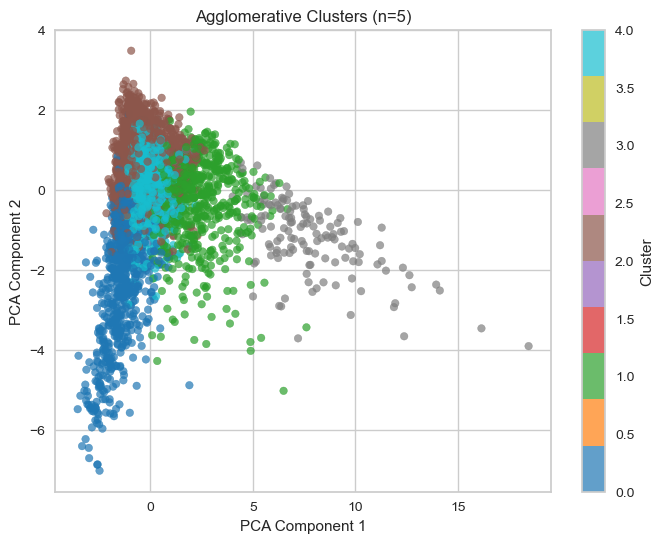

In [144]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', s=30, alpha=0.7)
plt.title(f'Agglomerative Clusters (n={n_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [145]:
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    cluster_movies = movies[movies['agg_cluster'] == i]
    print("Top genres:", pd.Series([g for genres in cluster_movies['genres'] for g in genres]).value_counts().head(5))
    print("Top directors:", cluster_movies['director'].value_counts().head(3))
    print("Example movies:", cluster_movies['title'].head(3).tolist())



Cluster 0:
Top genres: Drama        346
Comedy       290
Action       209
Thriller     209
Adventure    175
Name: count, dtype: int64
Top directors: director
Other               699
Alfred Hitchcock     21
Woody Allen          14
Name: count, dtype: int64
Example movies: ['Four Rooms', 'The City of Lost Children', 'Mortal Kombat']

Cluster 1:
Top genres: Action       231
Drama        207
Comedy       197
Adventure    185
Thriller     172
Name: count, dtype: int64
Top directors: director
Other               444
Steven Spielberg     17
Ridley Scott          9
Name: count, dtype: int64
Example movies: ['Toy Story', 'Jumanji', 'GoldenEye']

Cluster 2:
Top genres: Comedy      1065
Drama        975
Thriller     767
Action       658
Romance      452
Name: count, dtype: int64
Top directors: director
Other                2241
Renny Harlin           11
Richard Linklater      11
Name: count, dtype: int64
Example movies: ['Waiting to Exhale', 'Sudden Death', 'Cutthroat Island']

Cluster 3:
Top ge

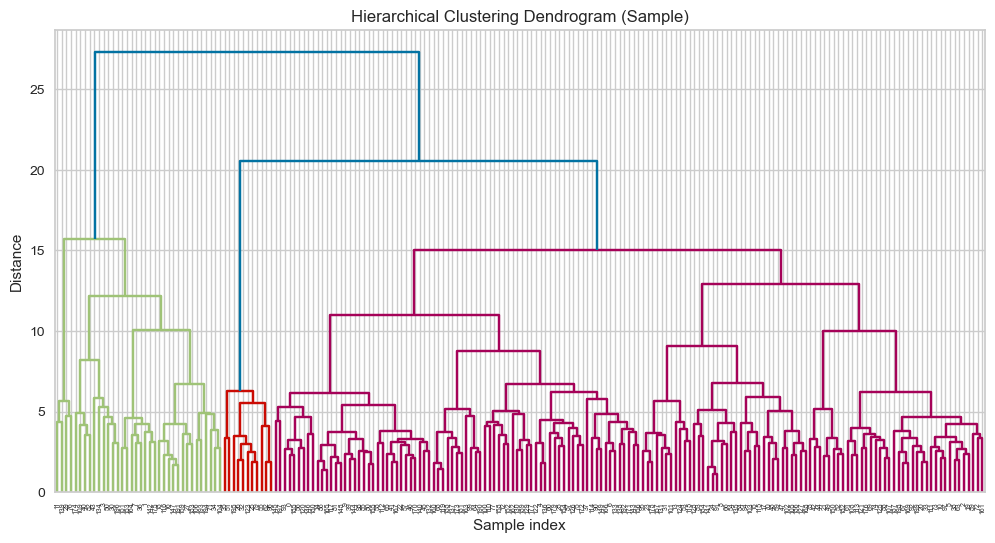

In [146]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Use a sample for visualization
sample_idx = np.random.choice(range(X.shape[0]), size=200, replace=False)
X_sample = X[sample_idx]

Z = linkage(X_sample, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Sample)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()


In [147]:
score = silhouette_score(X, labels)
print(f'Silhouette Score for Agglomerative Clustering (K={n_clusters}): {score:.3f}')

Silhouette Score for Agglomerative Clustering (K=5): 0.081


In [148]:
import joblib

# Exporting models
# KMeans
#joblib.dump(kmeans, '../models/kmeans_model.joblib')

# MeanShift
#joblib.dump(msmodel, '../models/meanshift_model.joblib')

# AgglomerativeClustering
#joblib.dump(agg, '../models/agg_model.joblib')

## Conclusion for clustering
None of the silhouette scores for my clustering models were very promising, but from my research that is to be expected with movie data, as they don't usually form naturally distinct clusers, especially with many overlapping features like genres and actors.
The highest score was from Mean Shift with a score of 0.386 - but that only groups movies into 3 clusters, and will most likely not be very representative and give good recommendations.

Combining my qualitative data and using NLP might be a better choice for providing better recommendations, which will be explored and implemented in tf-idf.ipynb